# Import libraries

In [4]:
import os
import sys
sys.path.append('../../')
import config
import pandas as pd
import pickle
import numpy as np

import text_preprocessing as tp
from openai_api import get_embedding
from predict import predict_text
from lazypredict.Supervised import LazyClassifier
from utils import save_results

from tqdm.notebook import tqdm
tqdm.pandas()

import warnings
warnings.filterwarnings('ignore')

from IPython.display import clear_output

# Load data

In [5]:
train_df = pd.read_parquet(config.DATASET_TWEETS_TRAIN_FILE)
test_df = pd.read_parquet(config.DATASET_TWEETS_TEST_FILE)

# Prepare data

### Clean data

In [6]:
train_df = train_df.drop_duplicates(['text'])
test_df = test_df.drop_duplicates(['text'])

train_df['text_preprocessed'] = train_df['text'].apply(lambda text: tp.text_preprocessing(text))
train_df = train_df[train_df['text_preprocessed'] != ""]
test_df['text_preprocessed'] = test_df['text'].apply(lambda text: tp.text_preprocessing(text))
test_df = test_df[test_df['text_preprocessed'] != ""]

In [7]:
print('train vaw: ', len(train_df[train_df['label'] == 1]))
print('train non vaw: ', len(train_df[train_df['label'] == 0]))
print('test vaw: ', len(test_df[test_df['label'] == 1]))
print('test non vaw: ', len(test_df[test_df['label'] == 0]))

train vaw:  689
train non vaw:  637
test vaw:  301
test non vaw:  263


### Get texts embeddings

In [ ]:
train_embeddings_filename = os.path.join(config.EMBEDDINGS_PATH, f'train_{len(train_df)}_words.csv')
if os.path.exists(train_embeddings_filename):
    embeddings_df = pd.read_csv(train_embeddings_filename)
    train_df['ada_embedding'] = embeddings_df["ada_embedding"].apply(eval).apply(np.array)
    train_df = train_df.dropna(axis=0, subset=['ada_embedding', 'text'])
else:
    train_df['ada_embedding'] = train_df['text_preprocessed'].progress_apply(lambda x: get_embedding(x, model='text-embedding-ada-002'))
    train_df.to_csv(train_embeddings_filename, index=False)


test_embeddings_filename = os.path.join(config.EMBEDDINGS_PATH, f'test_{len(test_df)}_words.csv')
if os.path.exists(test_embeddings_filename):
    embeddings_df = pd.read_csv(test_embeddings_filename)
    test_df['ada_embedding'] = embeddings_df["ada_embedding"].apply(eval).apply(np.array)
    test_df = test_df.dropna(axis=0, subset=['ada_embedding'])
else:
    test_df['ada_embedding'] = test_df['text_preprocessed'].progress_apply(lambda x: get_embedding(x, model='text-embedding-ada-002'))
    test_df.to_csv(test_embeddings_filename, index=False)

### Prepare model input

In [5]:
x_train = np.array(train_df['ada_embedding'].tolist())
y_train = np.array(train_df['label'].tolist())

x_test = np.array(test_df['ada_embedding'].tolist())
y_test = np.array(test_df['label'].tolist())

# Train models

### sklearn libraries

In [6]:
# Metrics calculation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report 

### Lazypredict - library for ml models

Train models

In [7]:
clf = LazyClassifier(verbose=False,ignore_warnings=True, custom_metric=None, predictions=True)

df_models_score,predictions = clf.fit(x_train, x_test, 
                             y_train, y_test)

models = clf.provide_models(x_train, x_test, 
                             y_train, y_test)

clear_output(wait=True)
df_models_score = df_models_score.reset_index()
df_models_score.head(10)


,Model,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
0,BaggingClassifier,0.63,0.64,0.64,0.64,7.37
1,NuSVC,0.66,0.63,0.63,0.66,0.44
2,RandomForestClassifier,0.67,0.62,0.62,0.66,2.29
3,GaussianNB,0.62,0.61,0.61,0.63,0.13
4,LGBMClassifier,0.63,0.61,0.61,0.63,2.93
5,KNeighborsClassifier,0.67,0.60,0.60,0.65,0.36
6,XGBClassifier,0.63,0.60,0.60,0.63,6.20
7,ExtraTreesClassifier,0.65,0.60,0.60,0.64,0.69
8,BernoulliNB,0.60,0.59,0.59,0.61,0.14
9,SVC,0.64,0.58,0.58,0.63,0.40


In [9]:
df_models_score

,Model,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
0,BaggingClassifier,0.63,0.64,0.64,0.64,7.37
1,NuSVC,0.66,0.63,0.63,0.66,0.44
2,RandomForestClassifier,0.67,0.62,0.62,0.66,2.29
3,GaussianNB,0.62,0.61,0.61,0.63,0.13
4,LGBMClassifier,0.63,0.61,0.61,0.63,2.93
5,KNeighborsClassifier,0.67,0.60,0.60,0.65,0.36
6,XGBClassifier,0.63,0.60,0.60,0.63,6.20
7,ExtraTreesClassifier,0.65,0.60,0.60,0.64,0.69
8,BernoulliNB,0.60,0.59,0.59,0.61,0.14
9,SVC,0.64,0.58,0.58,0.63,0.40


Get model results

Model name:  BaggingClassifier
Confusion Matrix :
[[44 21]
 [47 74]]
Accuracy Score : 0.6344086021505376
Report : 
              precision    recall  f1-score   support

           0       0.48      0.68      0.56        65
           1       0.78      0.61      0.69       121

    accuracy                           0.63       186
   macro avg       0.63      0.64      0.62       186
weighted avg       0.68      0.63      0.64       186



Model name:  NuSVC
Confusion Matrix :
[[34 31]
 [33 88]]
Accuracy Score : 0.6559139784946236
Report : 
              precision    recall  f1-score   support

           0       0.51      0.52      0.52        65
           1       0.74      0.73      0.73       121

    accuracy                           0.66       186
   macro avg       0.62      0.63      0.62       186
weighted avg       0.66      0.66      0.66       186



Model name:  RandomForestClassifier
Confusion Matrix :
[[28 37]
 [24 97]]
Accuracy Score : 0.6720430107526881
Report : 
    

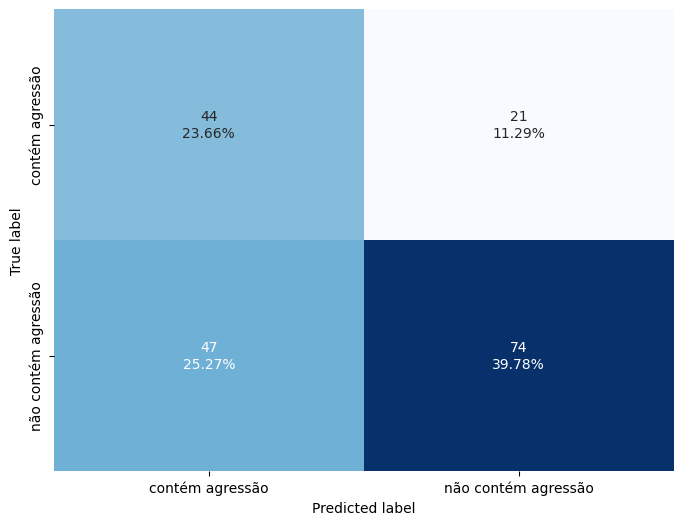

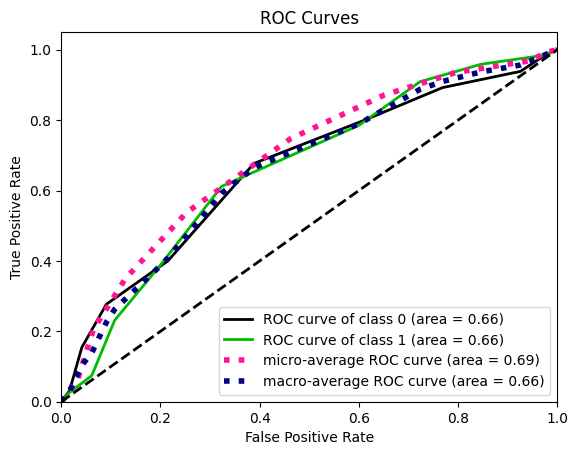

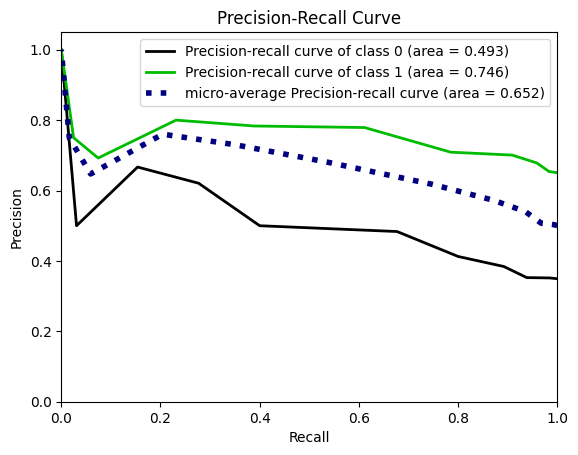

In [8]:
version_folder_path = os.path.join(config.DATA_PATH_MODELS, 'v10')
if not os.path.exists(version_folder_path):
    os.mkdir(version_folder_path)

df_models_score.to_csv(os.path.join(version_folder_path, 'all_results.csv'))
for i in range(5):
    current_clf = models[df_models_score.loc[i, 'Model']]

    model_path = os.path.join(version_folder_path, f'{df_models_score.loc[i, "Model"]}.pkl')
    with open(model_path, 'wb') as file:
        pickle.dump(current_clf, file)

    print('Model name: ', df_models_score.loc[i, 'Model'])
    results = {'true_labels': y_test}
    preds = predictions[df_models_score.loc[i, 'Model']]
    results['predictions'] = preds
    cm = confusion_matrix(y_test, preds) 
    results['cm'] = cm
    try:
        preds_proba = current_clf.predict_proba(x_test)
        results['predictions_probs'] = preds_proba
    except:
        pass
    
    print('Confusion Matrix :')
    print(cm) 
    print('Accuracy Score :', accuracy_score(y_test, preds)) 
    print('Report : ')
    print(classification_report(y_test, preds)) 
    print('\n')

    # Save best model
    if i == 0:
        best_model_path = os.path.join(config.DATA_PATH_MODELS, 'best.pkl')
        with open(best_model_path, 'wb') as file:
            pickle.dump(current_clf, file)
        
        summary_run = {
            'model_name': df_models_score.loc[i, 'Model'],
            'version': 0,
            'train_size': len(train_df),
            'test_size': len(test_df)
        }
        # save_file_folder = os.path.join(config.DATA_PATH_MODELS, 'best')
        # save_results(results, save_file_folder, summary_run)


# Verify predictions of the best model

In [108]:
version_dir = os.path.join(config.DATA_PATH_MODELS, 'v8')
file_path = os.path.join(version_dir, 'models_predictions_proba.csv')

df_predictions = pd.read_csv(file_path)
df_predictions = df_predictions.drop(df_predictions.columns[0], axis=1)
df_predictions

,AdaBoostClassifier,BaggingClassifier,BernoulliNB,CalibratedClassifierCV,DecisionTreeClassifier,DummyClassifier,ExtraTreeClassifier,ExtraTreesClassifier,GaussianNB,KNeighborsClassifier,...,Perceptron,QuadraticDiscriminantAnalysis,RandomForestClassifier,RidgeClassifier,RidgeClassifierCV,SGDClassifier,SVC,XGBClassifier,LGBMClassifier,True
0,0,0,0,1,0,1,0,1,0,1,...,1,0,1,1,1,1,0,0,1,1
1,1,1,0,1,0,1,0,1,1,1,...,1,0,1,1,1,1,1,1,1,1
2,0,1,0,1,1,1,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0
3,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,0,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555,1,1,1,1,0,1,0,1,1,1,...,1,0,1,0,0,0,1,1,1,0
556,0,0,1,1,0,1,0,1,1,1,...,0,0,1,1,1,0,1,1,1,0
557,1,1,1,1,0,1,0,0,1,1,...,1,0,1,1,1,1,1,1,0,0
558,0,0,0,0,1,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [91]:
def split_proba(row, model_name):
    non_vaw_proba = float(row[model_name][1:-1].split(' ')[0])
    vaw_proba = float(row[model_name][1:-1].split(' ')[1])

    new_row = {
        'non_vaw_proba': non_vaw_proba, 
        'vaw_proba': vaw_proba, 
        'true_label': float(row['True'])}
    ser = pd.Series(data=new_row, index=['non_vaw_proba', 'vaw_proba', 'true_label'])

    return ser

classifier_predictions = df_predictions.apply(lambda x: split_proba(x, 'ExtraTreesClassifier'), axis=1)

In [110]:
test_df = pd.read_parquet(config.DATASET_TWEETS_TEST_FILE)
test_df = test_df.drop_duplicates(['text'])
test_df['text_preprocessed'] = test_df['text'].apply(lambda text: tp.text_preprocessing(text))
test_df = test_df[test_df['text_preprocessed'] != ""]

test_embeddings_filename = os.path.join(config.EMBEDDINGS_PATH, f'test_{len(test_df)}_words.csv')
embeddings_df = pd.read_csv(test_embeddings_filename)
test_df['ada_embedding'] = embeddings_df["ada_embedding"].apply(eval).apply(np.array)
test_df = test_df.dropna(axis=0, subset=['ada_embedding'])

560

In [117]:
classifier_predictions = classifier_predictions.merge(test_df[['text', 'text_preprocessed']], left_index=True, right_index=True)
nv_classifier_predictions = classifier_predictions[classifier_predictions['true_label'] == 0]
v_classifier_predictions = classifier_predictions[classifier_predictions['true_label'] == 1]

In [129]:
# Top 10 classificações true positive (non vaw)
nv_tp = nv_classifier_predictions.sort_values(by='non_vaw_proba', ascending=False).head(15)
nv_tp[['non_vaw_proba', 'text', 'text_preprocessed']].to_csv('nv_tp.csv', index=False)
nv_tp

,non_vaw_proba,vaw_proba,true_label,text,text_preprocessed
452,1.00,0.00,0.00,Tem mlk q nem com testosterona vira homem kkkkk,mlk testosterona vira homem
39,1.00,0.00,0.00,"eu necessito, amo ser cadela de mulher https:/...",necessito amo ser cadela mulher
366,1.00,0.00,0.00,@Botafoguensesul @AdrianoMorrison @thalescmach...,respondi capaz sair proprias crencas coitadist...
448,1.00,0.00,0.00,@nohatluan vira homem comedia,vira homem comedia
453,1.00,0.00,0.00,Vira homem cachorro viado https://t.co/SGUOizLK0l,vira homem cachorro viado
407,0.75,0.25,0.00,Bem que ela falou num podcast que a guia espir...,bem falou podcast guia espiritual aconselhou t...
515,0.74,0.26,0.00,Cometi a leve atrocidade de me inscrever pro L...,cometi leve atrocidade inscrever pro letape ca...
314,0.71,0.29,0.00,PUTA QUE PARIU,puta pariu
246,0.71,0.29,0.00,Tô botando meus sintomas no Google e descobrin...,botando sintomas google descobrindo varias doe...
355,0.71,0.29,0.00,"nesse pique q o flamengo ta, vms descer pra sé...",nesse pique flamengo vms descer pra serie


In [130]:
# Top 10 classificações true negative (non vaw)
nv_tn = nv_classifier_predictions.sort_values(by='non_vaw_proba', ascending=True).head(15)
nv_tn[['vaw_proba', 'text', 'text_preprocessed']].to_csv('nv_tn.csv', index=False)
nv_tn

,non_vaw_proba,vaw_proba,true_label,text,text_preprocessed
447,0.00,1.00,0.00,@mfiinha @VEJA Mini vira homem,mini vira homem
410,0.00,1.00,0.00,"É bom tomar cuidado com o que fala, respeito é...",bom tomar cuidado fala respeito bom conserva d...
413,0.00,1.00,0.00,@Drmgoncalves1 Ele vai cozinhar neste campeona...,vai cozinhar neste campeonato fim epoca venho ...
456,0.00,1.00,0.00,vira homem bilionário viado https://t.co/zCC4D...,vira homem bilionario viado
478,0.00,1.00,0.00,@g1 VAI SIM PASPALHO. VA DE PIJAMA GOLPISTA C...,vai sim paspalho pijama golpista covarde
462,0.13,0.87,0.00,"Mal amada, mal comida, fofoqueira toda vida, f...",mal amada mal comida fofoqueira toda vida fura...
377,0.25,0.75,0.00,Tinha que ser mulher,ser mulher
493,0.27,0.73,0.00,Essa mulher é uma piranha https://t.co/YQFWOBhbeu,mulher piranha
129,0.30,0.70,0.00,Fui mal comida pelo meu marido vô humilhar meu...,mal comida marido humilhar alunos tirar vantagem
429,0.30,0.70,0.00,To comendo tanto esses dias deve ser tpm tenho...,comendo tanto dias deve ser tpm certeza diss


In [131]:
# Top 10 classificações true positive (vaw)
v_tp = v_classifier_predictions.sort_values(by='vaw_proba', ascending=False).head(15)
v_tp[['vaw_proba', 'text', 'text_preprocessed']].to_csv('v_tp.csv', index=False)
v_tp

,non_vaw_proba,vaw_proba,true_label,text,text_preprocessed
382,0.00,1.00,1.00,@DudaCampopiano tinha que ser mulher pra falar...,ser mulher pra falar porra dessa
3,0.00,1.00,1.00,além de burra é racista amor,alem burra racista amor
334,0.00,1.00,1.00,essa Simone devia trepar com o marido dela e p...,simone devia trepar marido parar passar trabal...
414,0.00,1.00,1.00,esse cu de planeta vai cozinhar nois vivo http...,planeta vai cozinhar nois vivo
416,0.00,1.00,1.00,@modelalecara @SomenteOrestes Vai lavar louça.,vai lavar louca
417,0.00,1.00,1.00,@dx_bebel Vai lavar louça que é melhor,vai lavar louca melhor
326,0.00,1.00,1.00,@michelonismo que mulher doida kkkk o gosto da...,mulher doida gosto cara gostoso
418,0.00,1.00,1.00,@Isaxzalves vai lavar louça,vai lavar louca
433,0.00,1.00,1.00,Ser mulher é fácil demais né\n\nÉ só mentir e ...,ser mulher facil demais mentir iludir
135,0.00,1.00,1.00,"Absurda essa série corpo em chamas, principalm...",absurda serie corpo chamas principalmente sabe...


In [132]:
# Top 10 classificações true negative (vaw)
v_tn = v_classifier_predictions.sort_values(by='vaw_proba', ascending=True).head(15)
v_tn[['non_vaw_proba', 'text', 'text_preprocessed']].to_csv('v_tn.csv', index=False)
v_tn

,non_vaw_proba,vaw_proba,true_label,text,text_preprocessed
444,1.00,0.00,1.00,viu ela tava pedindo p se corna https://t.co/Z...,viu tava pedindo pra corna
62,0.99,0.01,1.00,mulher e tudo igual.. tudo egoista.,mulher tudo igual tudo egoista
399,0.70,0.30,1.00,@marquesmaram @DFDanielFreitas Fala merda não!...,fala merda nao assassinato entrega adocao fech...
472,0.69,0.31,1.00,@aivialsen Dar nem palco para palhaço não liv....,dar palco palhaco liv deixa louca mal amada
379,0.64,0.36,1.00,@mandskkjkk Tinha que ser mulher,ser mulher
141,0.63,0.37,1.00,taylor swift cade você sua mocreia,taylor swift cade mocreia
384,0.63,0.37,1.00,tinha que ser mulher ne pqp https://t.co/ACy0t...,ser mulher porquep
28,0.63,0.37,1.00,Espero que a Demi dê um mata leão de jiu-jítsu...,espero demi mata leao jiujitsu nessa baranga a...
499,0.62,0.38,1.00,@XenaSapatao VAI SE FUDER ARROMBADA DO CARALHO...,vai fuder arrombada caralho merece ser espanca...
466,0.62,0.38,1.00,"VADIA, MAL AMADA, MAL COMIDA, NECESSITADA, PAS...",vadia mal amada mal comida necessitada passa f...
